In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier  # ✅ 4th model

sns.set(style="whitegrid")
pd.set_option('display.float_format', '{:.4f}'.format)


In [16]:
# %%
df = pd.read_csv("data.csv")
print("Dataset shape:", df.shape)
display(df.head())
display(df.info())
display(df['Bankrupt?'].value_counts(dropna=False))


Dataset shape: (6819, 96)


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.3706,0.4244,0.4057,0.6015,0.6015,0.9990,0.7969,0.8088,0.3026,...,0.7168,0.0092,0.6229,0.6015,0.8279,0.2902,0.0266,0.5641,1,0.0165
1,1,0.4643,0.5382,0.5167,0.6102,0.6102,0.9989,0.7974,0.8093,0.3036,...,0.7953,0.0083,0.6237,0.6102,0.8400,0.2838,0.2646,0.5702,1,0.0208
2,1,0.4261,0.4990,0.4723,0.6015,0.6014,0.9989,0.7964,0.8084,0.3020,...,0.7747,0.0400,0.6238,0.6014,0.8368,0.2902,0.0266,0.5637,1,0.0165
3,1,0.3998,0.4513,0.4577,0.5835,0.5835,0.9987,0.7970,0.8090,0.3033,...,0.7396,0.0033,0.6229,0.5835,0.8347,0.2817,0.0267,0.5647,1,0.0240
4,1,0.4650,0.5384,0.5223,0.5988,0.5988,0.9990,0.7974,0.8093,0.3035,...,0.7950,0.0039,0.6235,0.5988,0.8400,0.2785,0.0248,0.5756,1,0.0355


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

None

,count
Bankrupt?,
0,6599
1,220


In [17]:
print("Total missing values:", df.isna().sum().sum())

df.fillna(df.median(), inplace=True)

df['Bankrupt?'] = df['Bankrupt?'].astype(int)

Total missing values: 0


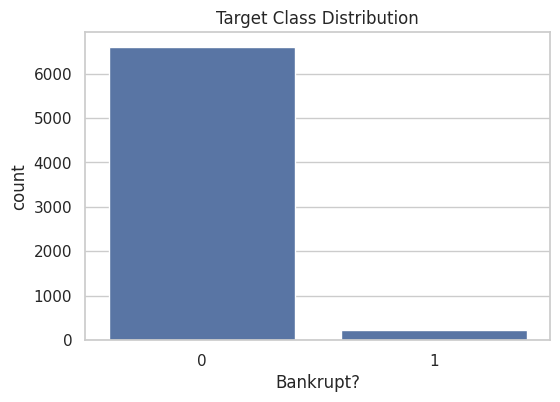

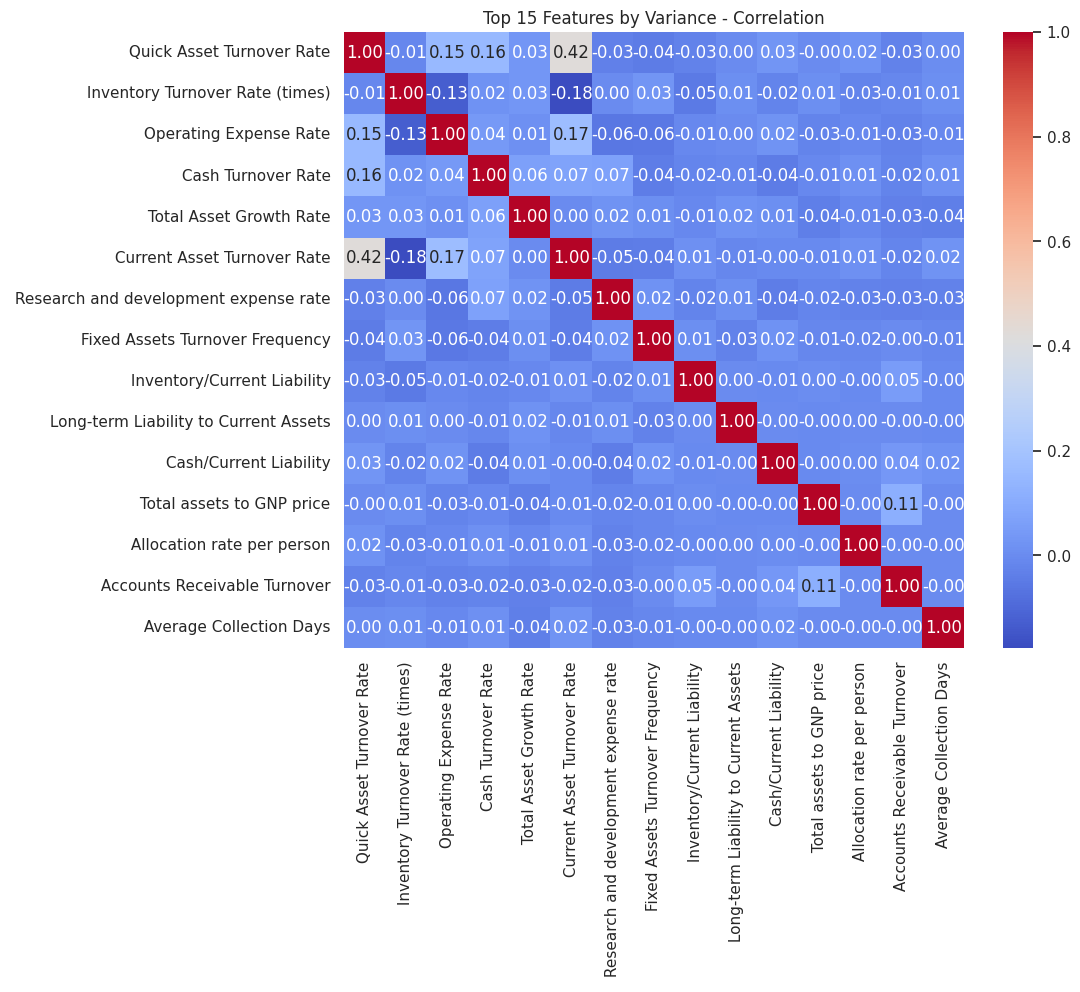

In [18]:
# %%
# 3. 📊 EDA - Exploratory Data Analysis
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Bankrupt?')
plt.title("Target Class Distribution")
plt.show()

# Correlation heatmap of most variable features
top_vars = df.var().sort_values(ascending=False).head(15).index
plt.figure(figsize=(10,8))
sns.heatmap(df[top_vars].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Top 15 Features by Variance - Correlation")
plt.show()

In [19]:
# 4. 🧼 Robust Outlier Detection and Removal (safer version)

numeric_cols = df.select_dtypes(include=[np.number]).columns.drop('Bankrupt?')
z_scores = np.abs(stats.zscore(df[numeric_cols]))

# Remove rows where more than 3 features have |z| > 3
outlier_rows = (z_scores > 3).sum(axis=1) > 3
removed_count = outlier_rows.sum()

# Only remove if we still keep at least 90% of the data
if len(df) - removed_count >= 0.9 * len(df):
    print(f"Removing {removed_count} rows with too many outliers.")
    df = df[~outlier_rows].reset_index(drop=True)
else:
    print("Skipping outlier removal to avoid losing too much data.")


Removing 321 rows with too many outliers.


/tmp/ipython-input-19-744379889.py:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_scores = np.abs(stats.zscore(df[numeric_cols]))


In [20]:
# 5. 🔍 Feature Selection & Scaling
X = df.drop(columns=['Bankrupt?'])
y = df['Bankrupt?']

selector = SelectKBest(score_func=f_classif, k=20)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()
print("Selected features:", selected_features)

# Scale selected features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# %%

Selected features: [' ROA(C) before interest and depreciation before interest', ' ROA(A) before interest and % after tax', ' ROA(B) before interest and depreciation after tax', ' Persistent EPS in the Last Four Seasons', ' Per Share Net profit before tax (Yuan ¥)', ' Total debt/Total net worth', ' Debt ratio %', ' Net worth/Assets', ' Borrowing dependency', ' Net profit before tax/Paid-in capital', ' Working Capital to Total Assets', ' Working Capital/Equity', ' Current Liabilities/Equity', ' Retained Earnings to Total Assets', ' Current Liability to Equity', ' Equity to Long-term Liability', ' Current Liability to Current Assets', ' Net Income to Total Assets', " Net Income to Stockholder's Equity", ' Liability to Equity']


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [84 93] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [21]:
# 6. 🧠 Model Training - 4 classifiers
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Train all models
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} ✅ Trained")

Logistic Regression ✅ Trained
Random Forest ✅ Trained
Gradient Boosting ✅ Trained


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:12:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost ✅ Trained



=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1897
           1       0.83      0.09      0.17        53

    accuracy                           0.97      1950
   macro avg       0.90      0.55      0.58      1950
weighted avg       0.97      0.97      0.97      1950



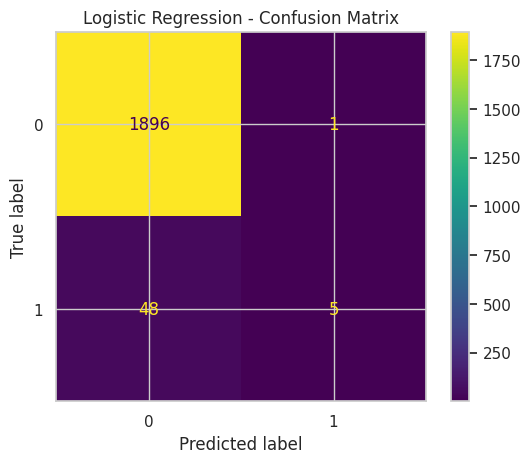


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1897
           1       0.71      0.09      0.17        53

    accuracy                           0.97      1950
   macro avg       0.84      0.55      0.58      1950
weighted avg       0.97      0.97      0.96      1950



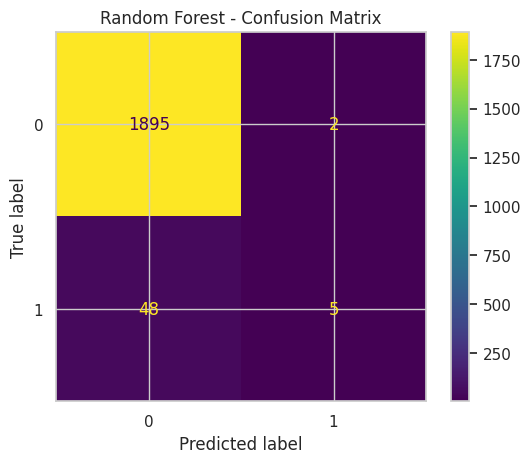


=== Gradient Boosting ===
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1897
           1       0.33      0.11      0.17        53

    accuracy                           0.97      1950
   macro avg       0.65      0.55      0.58      1950
weighted avg       0.96      0.97      0.96      1950



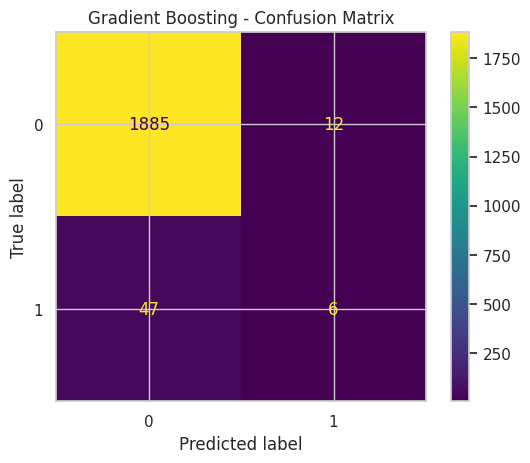


=== XGBoost ===
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1897
           1       0.50      0.17      0.25        53

    accuracy                           0.97      1950
   macro avg       0.74      0.58      0.62      1950
weighted avg       0.96      0.97      0.97      1950



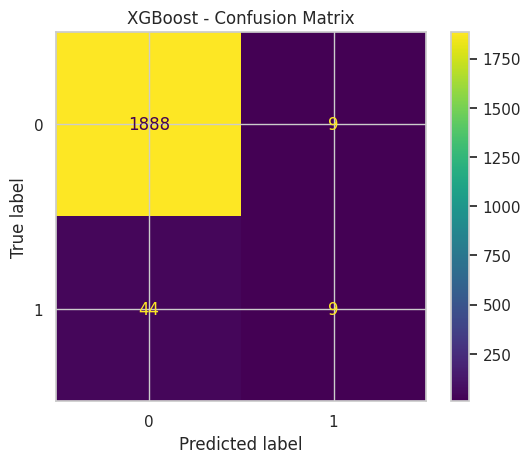

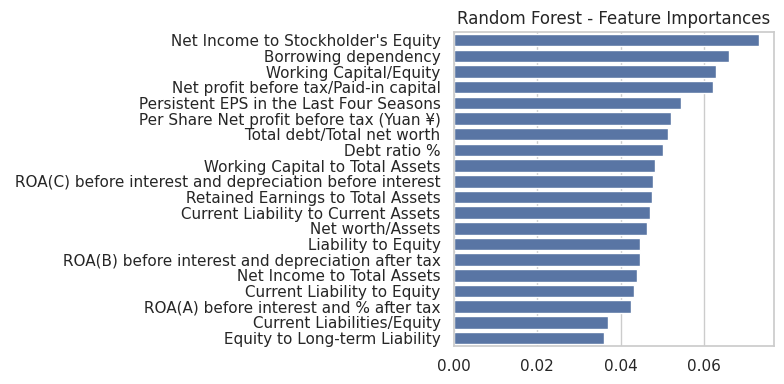

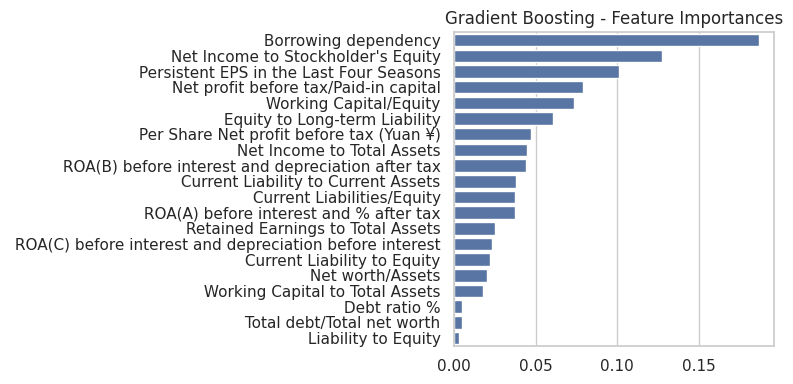

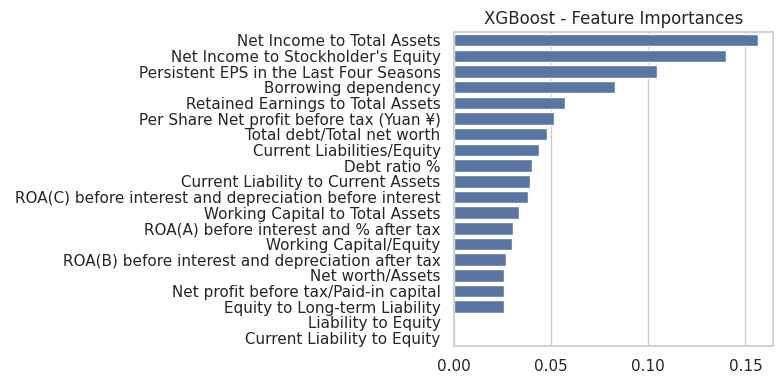

In [22]:
results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results[name] = {
        'Accuracy': acc,
        'ROC_AUC': auc,
        'Report': classification_report(y_test, y_pred, output_dict=True)
    }

    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

# Plot feature importances (tree-based models only)
tree_models = ['Random Forest', 'Gradient Boosting', 'XGBoost']
for name in tree_models:
    model = models[name]
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(8,4))
    sns.barplot(x=importances[indices], y=np.array(selected_features)[indices])
    plt.title(f"{name} - Feature Importances")
    plt.tight_layout()
    plt.show()

In [23]:
# 8. 🔁 Cross-validation and Grid Search Example
cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring='roc_auc')
    cv_results[name] = {
        'CV AUC Mean': scores.mean(),
        'CV AUC Std': scores.std()
    }
    print(f"{name} CV ROC AUC: {scores.mean():.4f} ± {scores.std():.4f}")

# Example: Grid search for XGBoost
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}
grid = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    param_grid, cv=3, scoring='roc_auc', n_jobs=-1
)
grid.fit(X_scaled, y)
print("\nBest XGBoost Params:", grid.best_params_)
print("Best CV AUC:", grid.best_score_)

# %%
# 🔚 Final Summary
print("\n📊 Final Model Summary:")
for name in results:
    print(f"{name} - Accuracy: {results[name]['Accuracy']:.4f}, "
          f"AUC: {results[name]['ROC_AUC']:.4f}, "
          f"CV AUC: {cv_results[name]['CV AUC Mean']:.4f}")

Logistic Regression CV ROC AUC: 0.9281 ± 0.0180
Random Forest CV ROC AUC: 0.8808 ± 0.0301
Gradient Boosting CV ROC AUC: 0.9160 ± 0.0238


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:12:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:12:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:12:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:13:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:13:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost CV ROC AUC: 0.9009 ± 0.0262

Best XGBoost Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Best CV AUC: 0.9196530799943154

📊 Final Model Summary:
Logistic Regression - Accuracy: 0.9749, AUC: 0.9346, CV AUC: 0.9281
Random Forest - Accuracy: 0.9744, AUC: 0.8898, CV AUC: 0.8808
Gradient Boosting - Accuracy: 0.9697, AUC: 0.9186, CV AUC: 0.9160
XGBoost - Accuracy: 0.9728, AUC: 0.9034, CV AUC: 0.9009


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:13:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
